# Federated Learning - Régression logistique 2D

### Ce fichier a pour but d'aider la visualisation du fonctionnement et des performances du Federated Learning via le Federated Averaging dans un contexte de régression logistique 2D avec 2 classes. Le but de notre modèle est donc de données une bonne prédiction quant à la probabilité d'appartenir à la classe 1.

In [1]:
# Importation des modules de génération de données
from FLSimulator import OneDimensionalRDG, OneDimensionalLRDG, TwoClusterGenerator

# Importation des modèles de machine learning disponibles
from FLSimulator import GDRegressor, LogisticRegressor

# Importation des modules pour créer un réseau fédéré
from FLSimulator import CentralServer, Node, FederatedNetwork

# Importation d'un module a utilisé comme fonction de base phi
from FLSimulator import polynomial_features

# Importation d'une fonction pour regrouper les données de façon centralisé
from FLSimulator import regroup_data_base

# Importation d'autres modules
from random import randint, choice, seed
from scipy.stats import multivariate_normal, norm
from matplotlib import pyplot as plt
import numpy as np

# Mise en place de variable global pour uniformiser des tests
E = 2 # Local Epochs done in each round of training
C = 1   # Minibatch size during in each round of training
eta0 = 0.5 # Initial learning rate
l_r = 'adaptive' # Learning rate schedule
agg = 'FedAvg' # Aggregation method
n_s = 'all' # Node selection
rand_size = 0.80 # Not used if n_s = 'all'
n_rounds = 25 # Number of rounds during distributed training
max_degree = 3 # Max polynomial basis function degree tested
nodes_qty = 10 # Number of nodes in the network
path = '/Users/Nick/Desktop/Pic/' # Path to store pictures
save_fig = False # Indicate if we save figures or not

# Mise en place des seeds
seed(9)
np.random.seed(2018)

### Créons un réseau fédéré simple constitué de 10 bases de données fédérées disposant de 150 à 250 observations partagées inégalement entre 2 classes dont les points seront tirés de distributions gaussiennes multivariées. Le positionnement des moyennes des distributions des classes ainsi que les matrices de covariances changeront légèrement entre chaque base de données fédérées pour éviter d'avoir des distributions de classes iid, soit obtenir une situation plus réaliste.

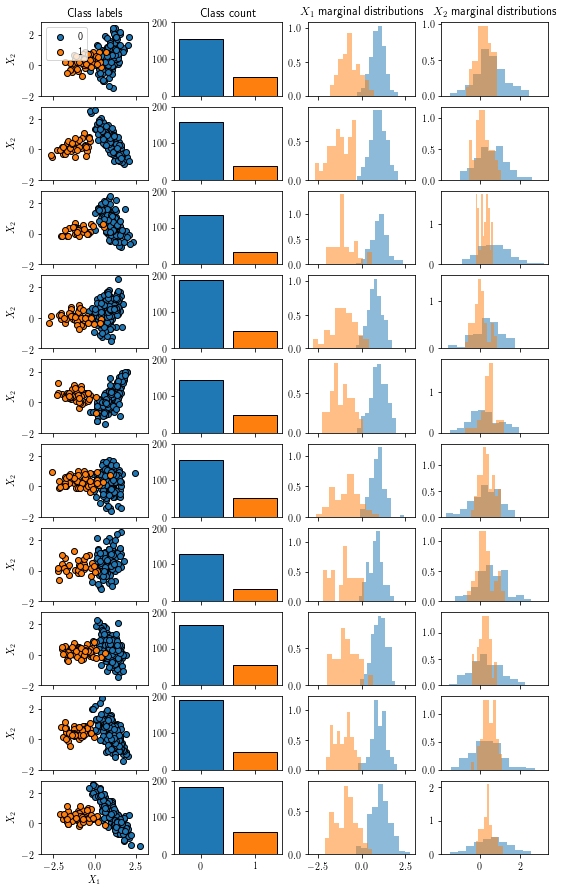

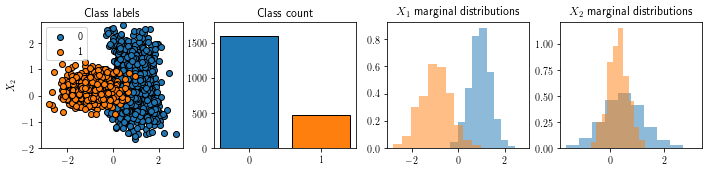

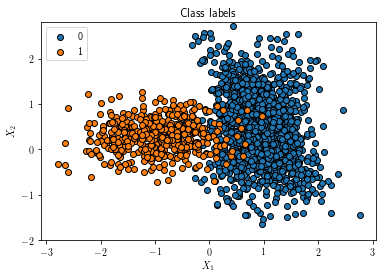

In [2]:
# Activation de LaTeX pour les illustrations
plt.rc('text', usetex=True)

# Création des Node
nodes = []
anti_diagonal = np.array([[0, 1], [1, 0]])
class_proportion = [0.20, 0.20, 0.20, 0.25, 0.25, 0.33, 0.50]
for i in range(nodes_qty):
    
    # We sample both cluster distribution mean from multivariate guaussians
    mu0 = multivariate_normal.rvs([0.95, 0.50], [0.015, 0.015])
    mu1 = multivariate_normal.rvs([-0.95, 0.35], [0.015, 0.015])
    
    # We select a random sample size between 150 and 250 for both clusters
    n = randint(150, 250)
    prop = choice(class_proportion)
    n0, n1 = int((1-prop)*n), int(prop*n)
    
    # We build covariance matrix for both clusters distribution
    cov0 = np.array([[0.40, 0], [0, 0.7]])
    cov1 = np.array([[0.65, 0], [0, 0.34]])
    
    # We add noises to term (0,1) and (1,0) of both covariance matrix
    lambda0 = norm.rvs(loc=0, scale=0.225)
    lambda1 = norm.rvs(loc=0, scale=0.08)
    cov0 += lambda0*anti_diagonal
    cov1 += lambda1*anti_diagonal
    
    # We multiply both covariance matrix by their tranpose to make sure they are positive semi-definite
    cov0 = np.matmul(cov0, cov0.T)
    cov1 = np.matmul(cov1, cov1.T)
    
    # We generate nodes
    X, t = TwoClusterGenerator.generate_data(sample_sizes=[n0, n1], centers=[mu0, mu1], covs=[cov0, cov1])
    nodes.append(Node(X, t))
    
# Illustration de l'ensemble des noeuds
TwoClusterGenerator.distribution_and_labels(Xs=[node.X for node in nodes], ts=[node.t for node in nodes],
                                            save=save_fig, save_path=path, filename='nodes', save_format='.pdf')
    
# Illustration de la base de données si elle était centralisée
X_total, t_total = regroup_data_base(nodes)
n_total = X_total.shape[0]
TwoClusterGenerator.distribution_and_labels([X_total], [t_total], sub_height=2.5, sub_width=10, count_max=1800,
                                           save=save_fig, save_path=path, filename='overall_distribution', save_format='.pdf')
TwoClusterGenerator.plot_labels(X_total, t_total, title='Class labels', legend=True, 
                                save=save_fig, save_path=path, filename='binary_classification', save_format='.eps')






### On effectue maintenant 25 "rounds" d'entraînements de différents modèles de régression logistique distribués et visualisons leurs performances à jour entre chaque "round" en regroupant l'ensemble des bases de données dans une figure commune.

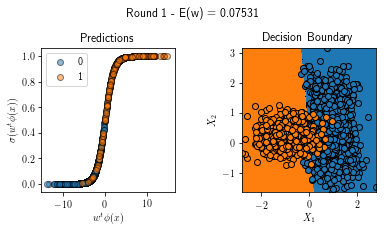

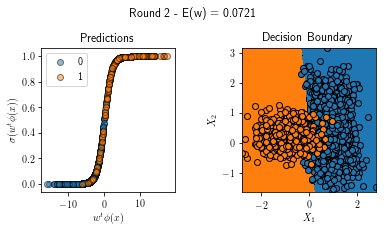

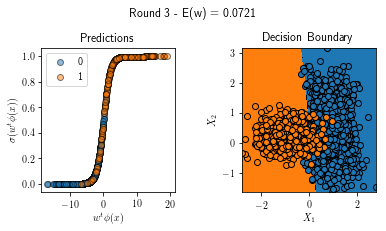

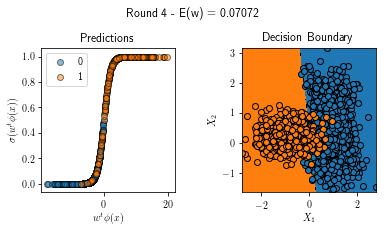

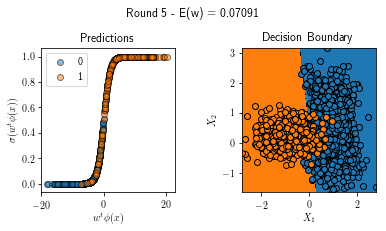

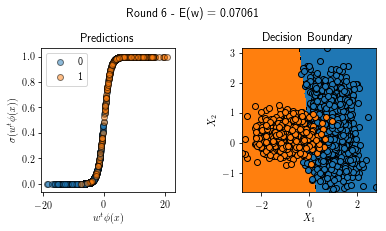

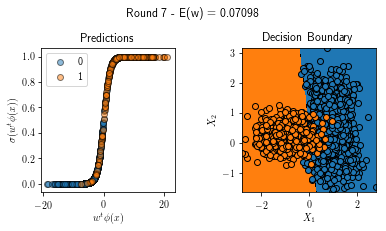

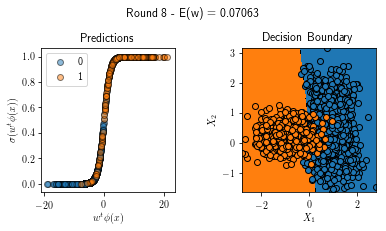

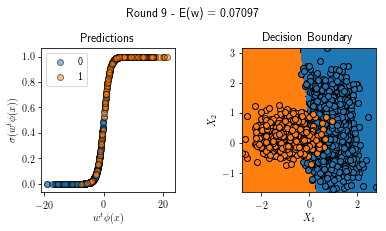

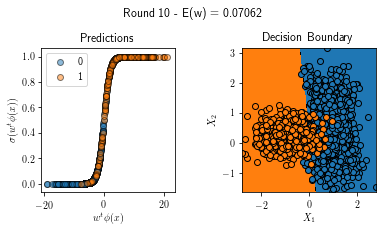

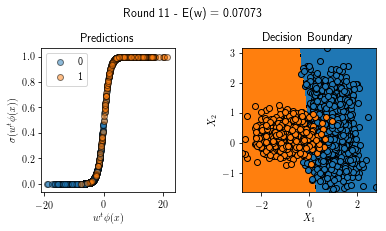

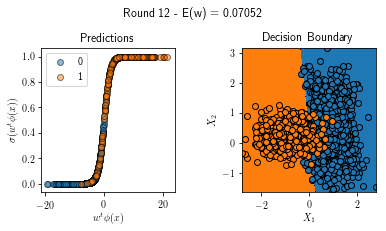

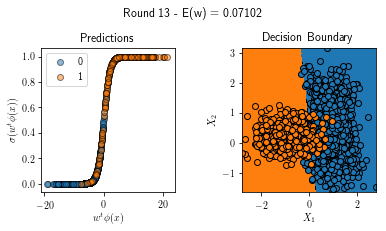

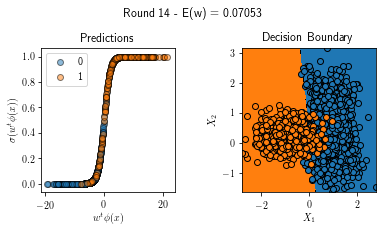

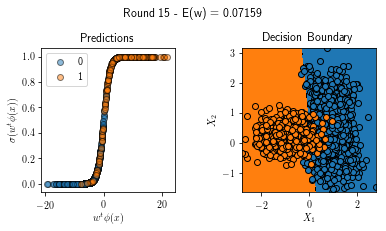

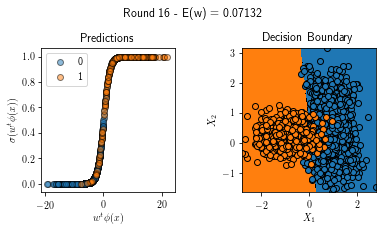

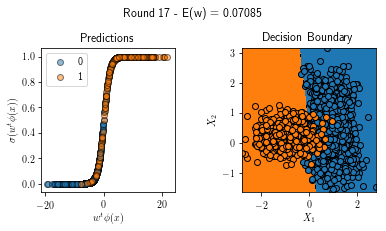

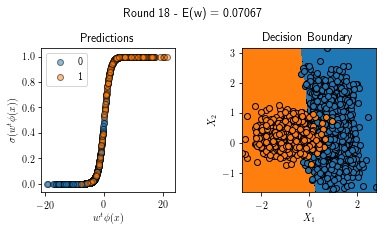

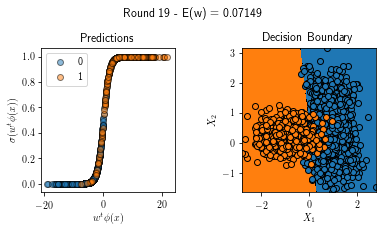

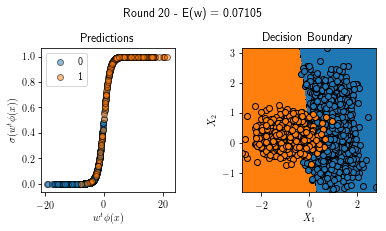

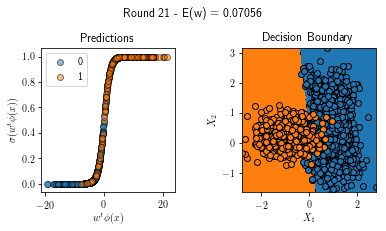

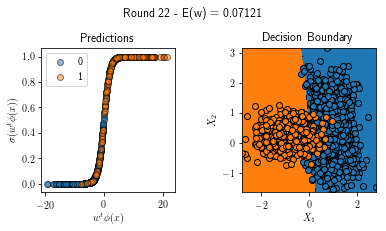

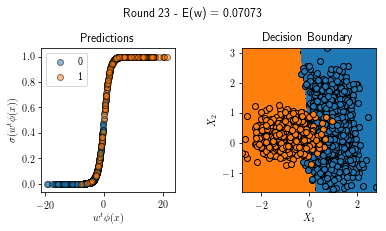

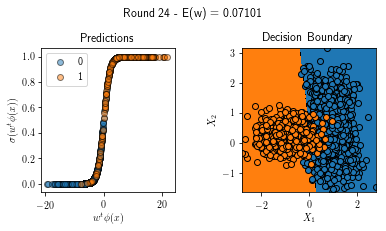

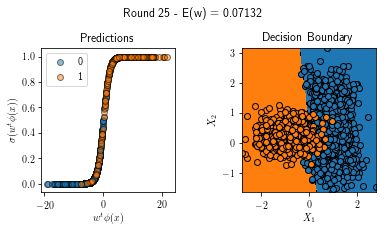



 Training of degree 1 model completed 




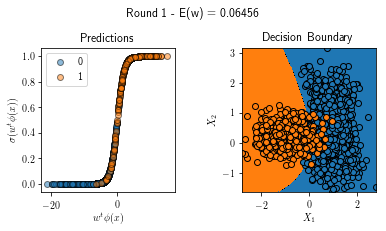

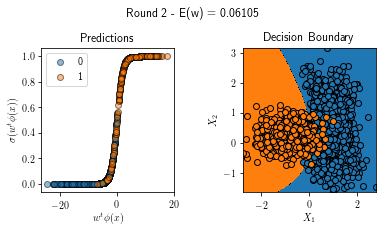

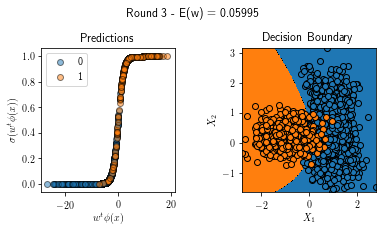

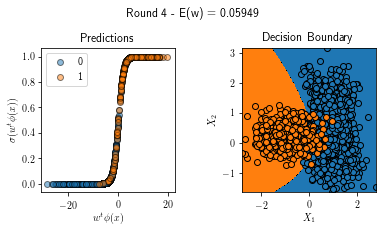

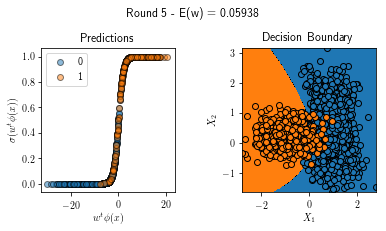

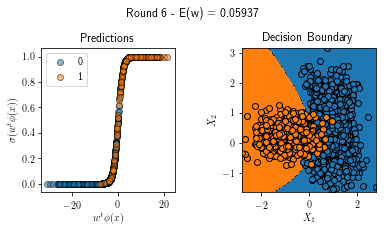

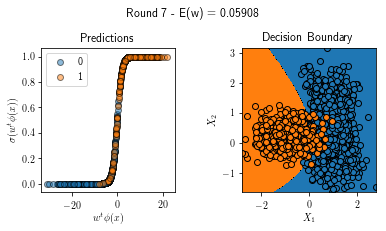

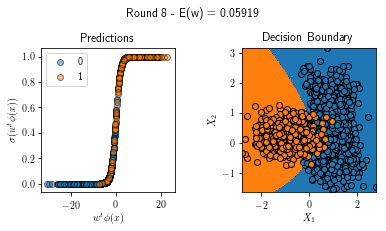

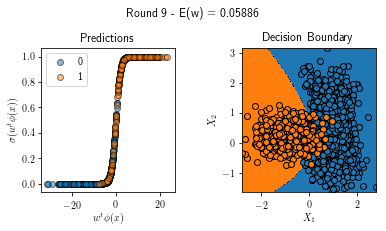

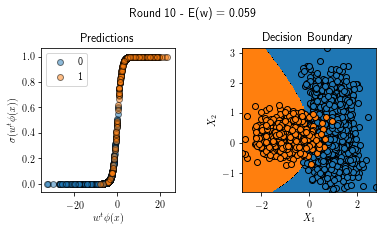

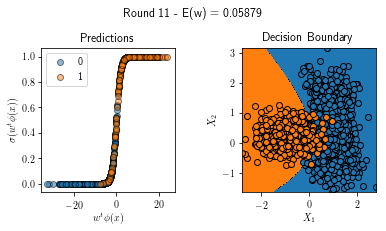

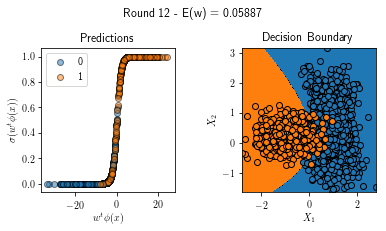

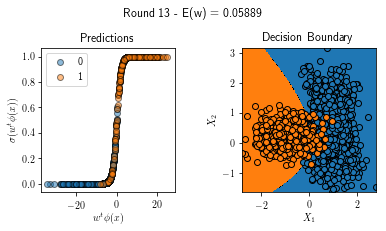

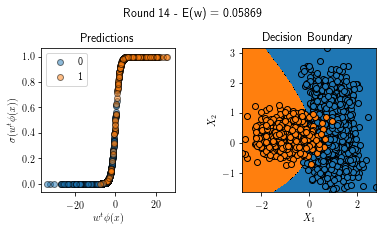

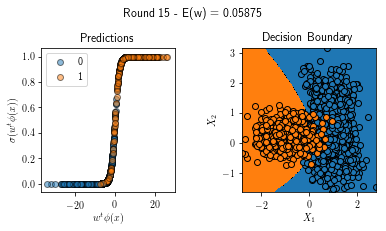

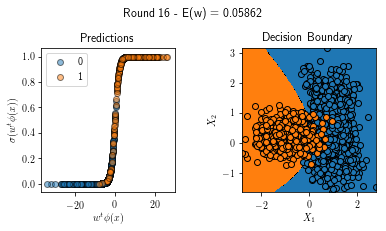

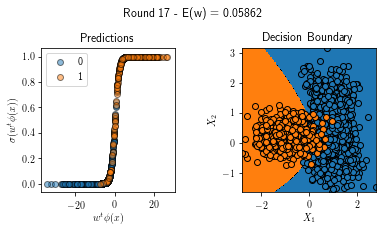

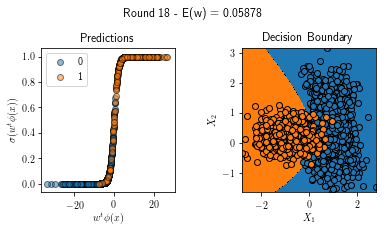

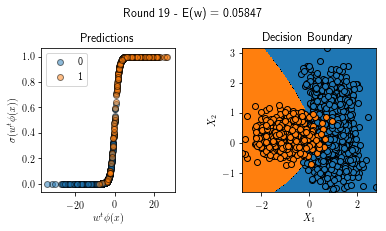

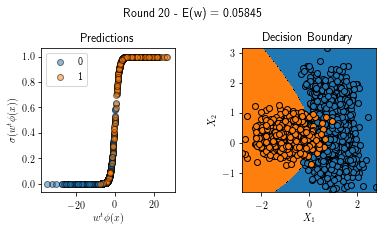

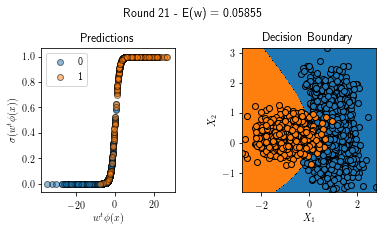

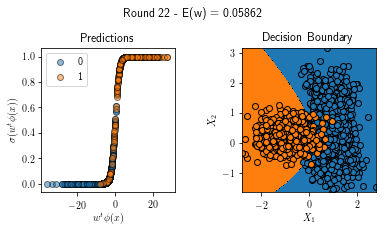

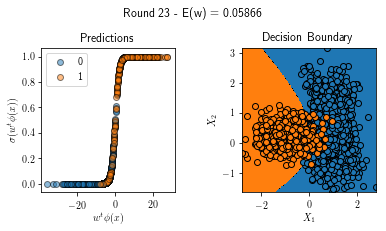

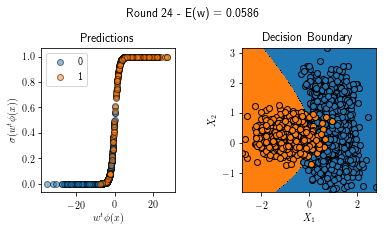

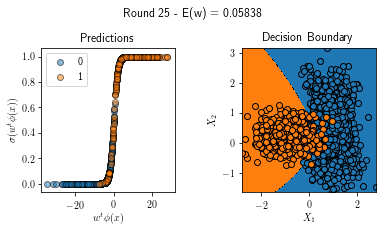



 Training of degree 2 model completed 




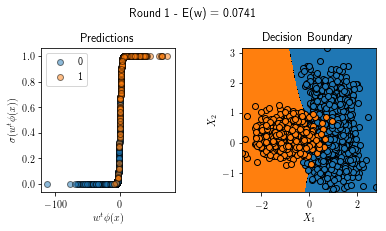

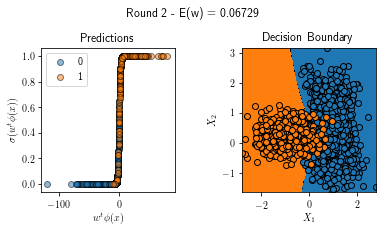

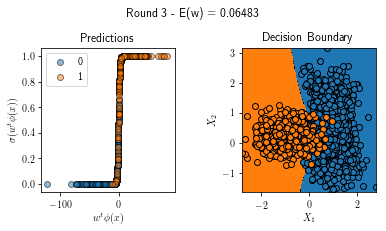

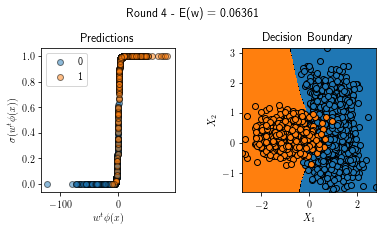

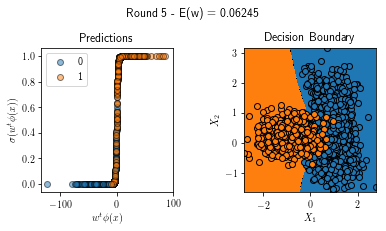

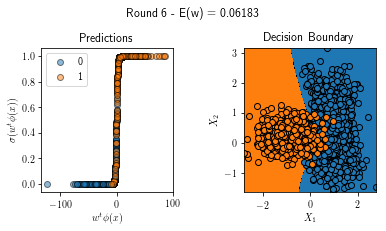

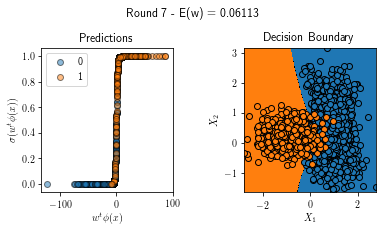

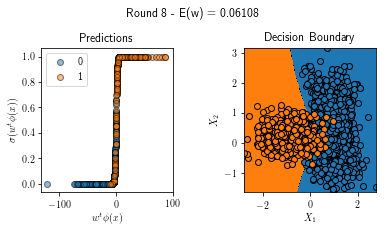

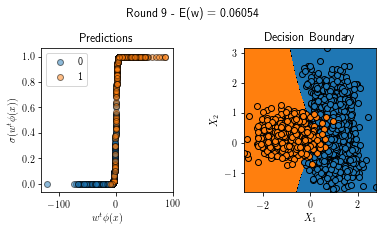

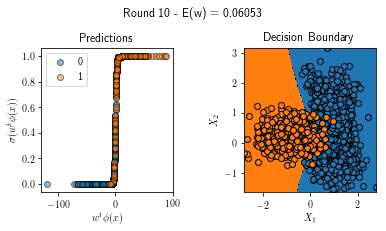

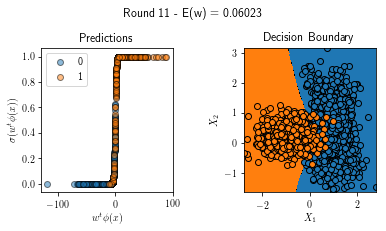

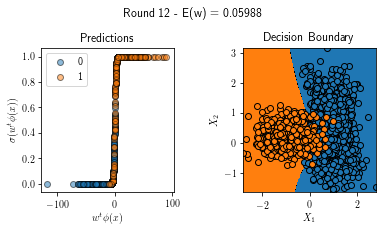

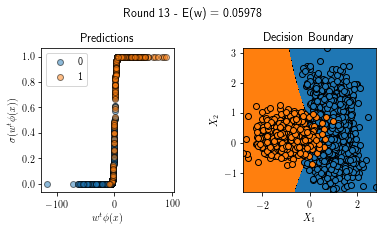

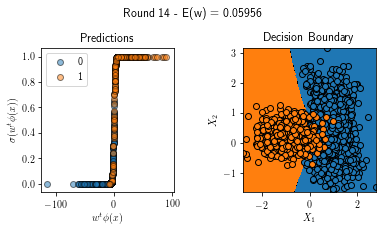

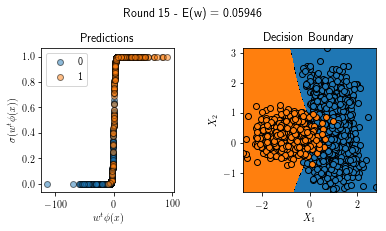

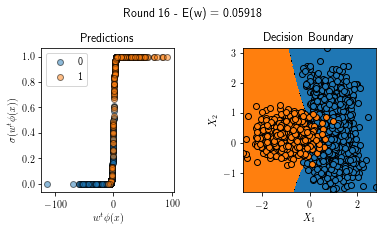

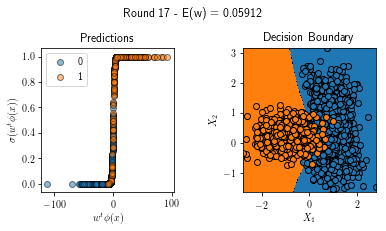

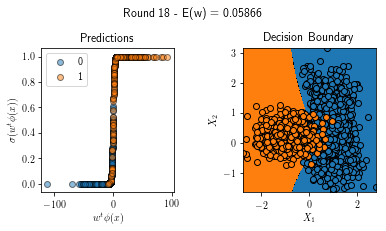

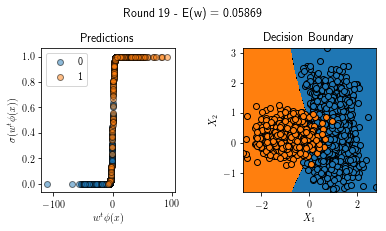

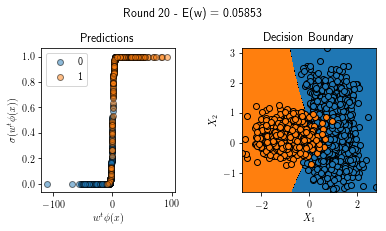

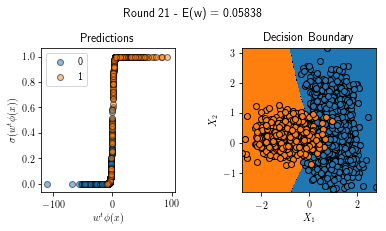

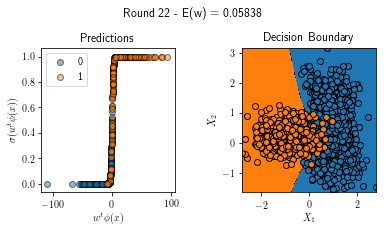

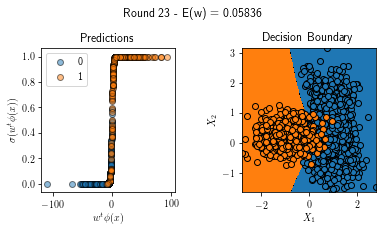

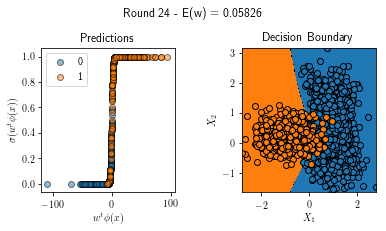

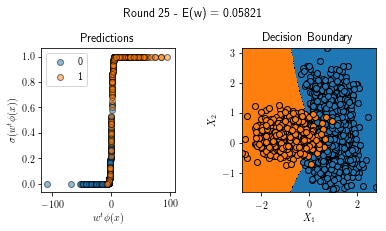



 Training of degree 3 model completed 




In [3]:
# Créations d'une list pour garder les différents modèles distribués en mémoire
distributed_models = []

# Création d'une list de list qui contient la progression des loss de chaque modèle au fil des rounds
losses_progression = []

# Création d'une list qui contiendra les weights initiaux des modèles globales
init_weights = []

for i in range(max_degree):

    # Création du modèle global qui sera entraîné et partagé par le réseau
    # Modèle de régression logistique avec fonction de base polynomial de degré i+1
    m = LogisticRegressor(phi=polynomial_features(i+1), eta0=eta0, learning_rate=l_r)
    
    # Sauvegarde des weights initiaux
    init_weights.append(m.w)

    # Création du server central
    c_server = CentralServer(global_model=m, aggregation=agg, node_selection=n_s, C=C, E=E, random_size=rand_size)

    # Création du réseau fédéré
    f_network = FederatedNetwork(c_server, nodes)

    # Entraînement du réseau
    loss_prog = f_network.run_learning(nb_of_rounds=n_rounds, show_round_results=True, loss_progress=True,
                                       save_round_figs=False, save_path=path, filename='deg3', save_format='.pdf')
    
    # Sauvegarde
    distributed_models.append(m)
    losses_progression.append(loss_prog)
    
    print('\n\n', 'Training of degree ' + str(i+1) + ' model completed', '\n\n')
    

### Entrainons également de façons centralisé les modèles de degré 1, 2, 3 et 4. 


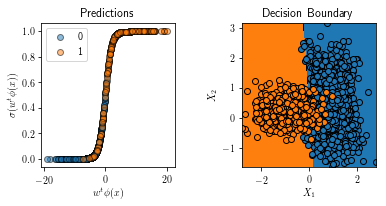

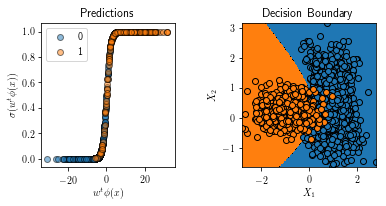

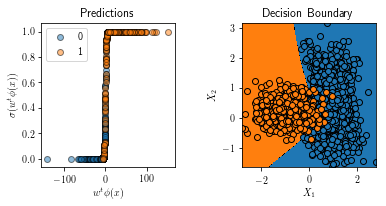

In [4]:
# Variables to store results
local_models = []
losses = []

for i in range(max_degree):
    
    # Modèle centralisé de degré i+1
    local_model = LogisticRegressor(phi=polynomial_features(i+1), eta0=eta0, learning_rate='adaptive')
    local_model.train(X_total, t_total, minibatch_size=C, nb_epoch=(E*n_rounds), weight_init=init_weights[i])
    loss = round(local_model.loss(X_total, t_total)/n_total, 5)
    local_model.plot_model(X_total, t_total, save=False, save_path=path, filename='quadratic_centralized_sol', save_format='.pdf')

    local_models.append(local_model)
    losses.append(loss)




### Comparons la progression des loss au fil des rounds pour les différents modèles ainsi que le modèle centralisé.

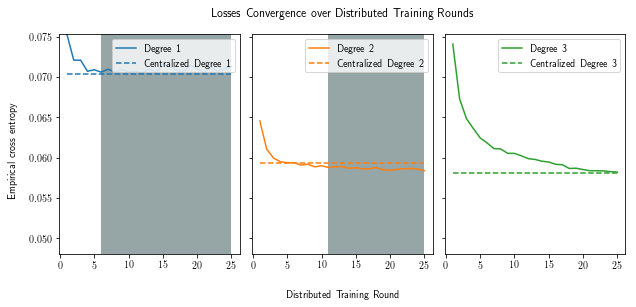

In [6]:
# We set some values for axis settings
round_range = list(range(1, n_rounds + 1))
max_y = max([losses_progression[i][0] for i in range(max_degree)])
min_y = min(losses) - 0.01

# We compute break points where training should have stop
brk_pt = [n_rounds]*max_degree
lp = losses_progression
eps = 0.0000700001
for i in range(max_degree):
    for j in range(3, len(lp[i])):
        if lp[i][j-3] - lp[i][j] <= eps:
            brk_pt[i] = j
            break

# We plot the loss progression of each model
fig, axes = plt.subplots(nrows=1, ncols=max_degree, sharey='row', figsize=(10, 5))
for k in range(max_degree):
    axes[k].axvspan(brk_pt[k], n_rounds, facecolor=(0.1843, 0.3098, 0.3098), alpha=0.5)
    axes[k].set_ylim(min_y, max_y)
    axes[k].plot(round_range, losses_progression[k], '-', label='Degree ' + str(k+1), c='C'+str(k))
    axes[k].plot(round_range, [losses[k]]*len(round_range), '--', label='Centralized Degree ' + str(k+1), c='C'+str(k))
    axes[k].legend(loc='upper right')
    
fig.suptitle('Losses Convergence over Distributed Training Rounds', x=0.52, y=0.90)
fig.text(0.52, 0.1, 'Distributed Training Round', ha='center', va='center')
fig.text(0.06, 0.5, 'Empirical cross entropy', ha='center', va='center', rotation='vertical')
fig.tight_layout(pad=6, w_pad=0.5, h_pad=3)
# plt.savefig('/Users/Nick/Desktop/Pic/losses_convergence.pdf', format='pdf')
plt.show()
    


### Regardons les différences des loss entre les modèles distribués et leur semblables centralisés au fil des rounds

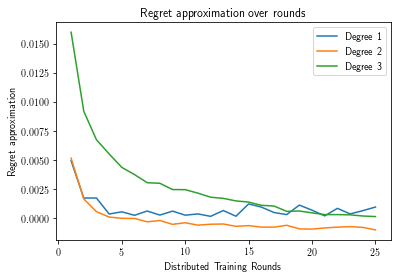

In [7]:
round_range = range(1,26)


for i in range(max_degree):
    diff = np.array([losses_progression[i]]) - losses[i]
    plt.plot(round_range, diff[0],'-', label='Degree ' + str(i+1))

plt.legend(loc='upper right')
plt.title('Regret approximation over rounds')
plt.xlabel('Distributed Training Rounds')
plt.ylabel('Regret approximation')
plt.show()

